In [1]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42

In [2]:
datasets = Path('datasets')

data_labels = {}

for i, dir in enumerate(datasets.iterdir()):
    data_labels[dir.name] = i

data_labels

{'Coffee machines': 0,
 'Computers stations (with monitors)': 1,
 'Fridges and freezers': 2,
 'Hi-Fi systems (with CD players)': 3,
 'Lamps (compact fluorescent)': 4,
 'Laptops (via chargers)': 5,
 'Microwave ovens': 6,
 'Mobile phones (via chargers)': 7,
 'Printers': 8,
 'Televisions (LCD or LED)': 9}

In [3]:
colnames = ['phAngle', 'freq', 'reacPower', 'power', 'rmsVolt', 'rmsCur']

data = []
labels = []

for dir in datasets.iterdir():
    label = datasets / dir.name

    for file in label.iterdir():
        
        with open(file, 'r') as f:
            file_content = f.readlines()
        
        file_content = [line[1:-2] for line in file_content if line[0] != '#']
        columns = np.array([list(map(float, row.split(' '))) for row in file_content])
        padded = tf.keras.preprocessing.sequence.pad_sequences(columns, maxlen=360, dtype='float32', padding='pre').T

        data.append(padded)
        labels.append(data_labels[file.parent.name])

data, labels = np.array(data), np.array(labels)

data.shape, labels.shape

((200, 360, 6), (200,))

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin


class Reshape3DTo2D(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(-1, 6)
    

class Reshape2DTo3D(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(-1, 360, 6)

In [5]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


preprocess = Pipeline([
    ('to2D', Reshape3DTo2D()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('to3D', Reshape2DTo3D())
])

preprocess

Pipeline(steps=[('to2D', Reshape3DTo2D()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()), ('to3D', Reshape2DTo3D())])

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_validate, Y_train, Y_validate = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=SEED)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_validate, Y_validate, test_size=0.4, stratify=Y_validate, random_state=SEED)

In [7]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(360, 6)),
        tf.keras.layers.LSTM(units=128, return_sequences=True),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(units=10, activation='softmax'),
    ])

model = make_model()
model.load_weights('started.weights.h5')

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
              metrics=['accuracy']
)

# model.summary()

mc = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True)

preprocess.fit(X_train)
history = model.fit(
    preprocess.transform(X_train),
    tf.keras.utils.to_categorical(Y_train),
    validation_data=(preprocess.transform(X_validate), tf.keras.utils.to_categorical(Y_validate)),
    batch_size=4,
    epochs=100,
    callbacks=[mc],
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2209 - loss: 2.1672 - val_accuracy: 0.4667 - val_loss: 1.6948
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4810 - loss: 1.6037 - val_accuracy: 0.4000 - val_loss: 1.5389
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4884 - loss: 1.4339 - val_accuracy: 0.6333 - val_loss: 1.2508
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5454 - loss: 1.2248 - val_accuracy: 0.7333 - val_loss: 1.1069
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6577 - loss: 1.0748 - val_accuracy: 0.7667 - val_loss: 0.9556
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6900 - loss: 0.9538 - val_accuracy: 0.7000 - val_loss: 1.0657
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7028 - loss: 1.0453 - val_accuracy: 0.7667 - val_loss: 1.0126
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6283 - loss: 1.0082 - val_accuracy: 0.

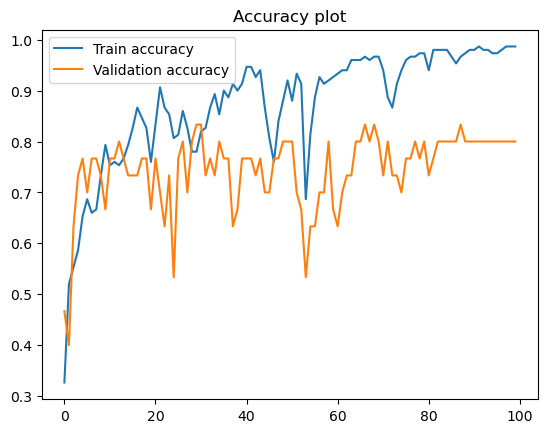

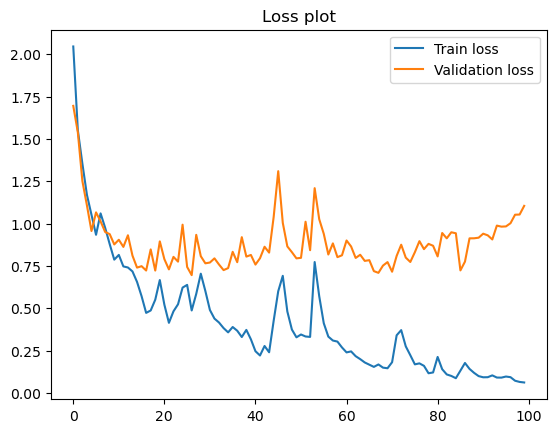

In [8]:
plt.plot(history.epoch, history.history['accuracy'], label='Train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy plot')
plt.show()

plt.plot(history.epoch, history.history['loss'], label='Train loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss plot')
plt.show()

Test accuracy: 0.85
Test recall: 0.85
Test precision: 0.9
Test f1: 0.8400000000000001


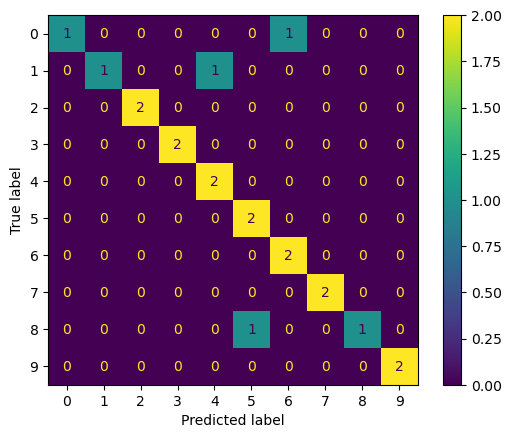

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score

# model = tf.keras.models.load_model('best_model.keras')

preds = np.argmax(model.predict(preprocess.transform(X_test), verbose=0), axis=1)

results = pd.DataFrame({
    'preds': preds,
    'true': Y_test
})

print(f'Test accuracy: {accuracy_score(results['true'], results['preds'])}')
print(f'Test recall: {recall_score(results['true'], results['preds'], average='weighted')}')
print(f'Test precision: {precision_score(results['true'], results['preds'], average='weighted')}')
print(f'Test f1: {f1_score(results['true'], results['preds'], average='weighted')}')

cm = confusion_matrix(results['true'], results['preds'])
ConfusionMatrixDisplay(cm).plot()